In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
import optax

# Potential and equilibrium points

2024-05-18 18:56:01.292167: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


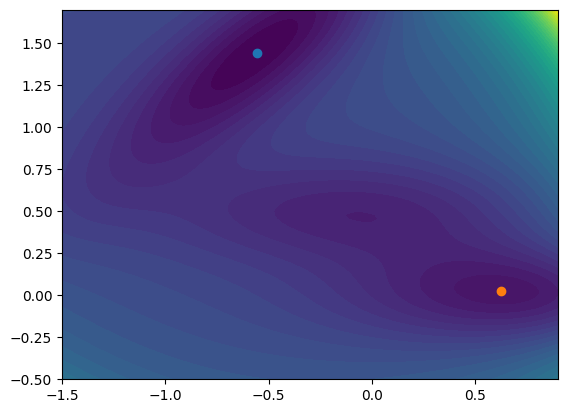

In [3]:
A = jnp.array([[-0.55828035, 1.44169]])
B = jnp.array([[0.62361133, 0.02804632]])
ndim = A.shape[1]
T = 1.0
k, Temp, gamma = 1.0, 1.0, 1.0
m = jnp.array([[1.0, 2.0]])
xi = jnp.sqrt(2*k*Temp/(m*gamma)) # notation of Dellago eq. 19

def U(xs, scale1=0.15, scale2=15, beta=1.0):
    x, y = xs[:, 0], xs[:, 1]
    e1 = -200 * jnp.exp(-(x -1)**2 -10 * y**2)
    e2 = -100 * jnp.exp(-x**2 -10 * (y -0.5)**2)
    e3 = -170 * jnp.exp(-6.5 * (0.5 + x)**2 +11 * (x +0.5) * (y -1.5) -6.5 * (y -1.5)**2)
    e4 = 15.0 * jnp.exp(0.7 * (1 + x)**2 +0.6 * (x +1) * (y -1) +0.7 * (y -1)**2) + 146.7
    out = beta * (scale1 * (e1 + e2 + e3 + e4))
    return out

x,y = np.linspace(-1.5,0.9,100), np.linspace(-0.5,1.7,100)
x,y = np.meshgrid(x,y)
z = U(np.stack([x,y], -1).reshape(-1,2)).reshape([100,100])
plt.contourf(x,y,z,50)
plt.scatter(A[0,0], A[0,1])
plt.scatter(B[0,0], B[0,1])

# MLPs and the loss function

In [4]:
class MLPq(nn.Module):
  @nn.compact
  def __call__(self, t):
    t = t/T
    h_mu = (1-t)*A + t*B
    S_0 = 1e-2*jnp.eye(ndim)
    S_0 = S_0[None,...]
    h_S = (1-2*t*(1-t))[...,None]*S_0
    h = jnp.hstack([h_mu, h_S.reshape(-1,ndim*ndim), t])
    h = nn.Dense(256)(h)
    h = nn.swish(h)
    h = nn.Dense(256)(h)
    h = nn.swish(h)
    h = nn.Dense(256)(h)
    h = nn.swish(h)
    h = nn.Dense(ndim + ndim*ndim)(h)
    mu = h_mu + (1-t)*t*h[:,:ndim]
    S = h[:,ndim:].reshape(-1,ndim,ndim)
    S = jnp.tril(2*jax.nn.sigmoid(S) - 1.0, k=-1) + jnp.eye(ndim)[None,...]*jnp.exp(S)
    S = h_S + 2*((1-t)*t)[...,None]*S
    return mu, S

In [5]:
q = MLPq()

BS = 512
key = jax.random.PRNGKey(1)
key, *init_key = jax.random.split(key, 3)
params_q = q.init(init_key[0], jnp.ones([BS, 1]))

optimizer_q = optax.adam(learning_rate=1e-4)
state_q = train_state.TrainState.create(apply_fn=q.apply,
                                        params=params_q,
                                        tx=optimizer_q)

In [6]:
def loss_fn(params_q, key):
  key = jax.random.split(key)
  t = T*jax.random.uniform(key[0], [BS,1])
  eps = jax.random.normal(key[1], [BS,ndim,1])

  mu_t = lambda _t: state_q.apply_fn(params_q, _t)[0]
  S_t = lambda _t: state_q.apply_fn(params_q, _t)[1]
  def dmudt(_t):
    _dmudt = jax.jacrev(lambda _t: mu_t(_t).sum(0))
    return _dmudt(_t).squeeze().T
  def dSdt(_t):
    _dSdt = jax.jacrev(lambda _t: S_t(_t).sum(0))
    return _dSdt(_t).squeeze().T
  dUdx_fn = jax.grad(lambda _x: U(_x).sum())
  def drift(_x):
    return -dUdx_fn(_x)/(gamma*m)
  def v_t(_eps, _t):
    S_t_val, dSdt_val = S_t(_t), dSdt(_t)
    _x = mu_t(_t) + jax.lax.batch_matmul(S_t_val, _eps).squeeze()
    dlogdx = -jax.scipy.linalg.solve_triangular(jnp.transpose(S_t_val, (0,2,1)), _eps)
    # S_t_val_inv = jnp.transpose(jnp.linalg.inv(S_t_val), (0,2,1))
    # dlogdx = -jax.lax.batch_matmul(S_t_val_inv, _eps)
    dSigmadt = jax.lax.batch_matmul(dSdt_val, jnp.transpose(S_t_val, (0,2,1)))
    dSigmadt += jax.lax.batch_matmul(S_t_val, jnp.transpose(dSdt_val, (0,2,1)))
    u_t = dmudt(_t) - 0.5*jax.lax.batch_matmul(dSigmadt, dlogdx).squeeze()
    out = (u_t - drift(_x)) + 0.5*(xi**2)*dlogdx.squeeze()
    return out
  loss = 0.5*((v_t(eps, t)/xi)**2).sum(1, keepdims=True)
  print(loss.shape, 'loss.shape', flush=True)
  return loss.mean()

@jax.jit
def train_step(state_q, key):
  grad_fn = jax.value_and_grad(loss_fn, argnums=0)
  loss, grads = grad_fn(state_q.params, key)
  state_q = state_q.apply_gradients(grads=grads)
  return state_q, loss

key, loc_key = jax.random.split(key)
state_q, loss = train_step(state_q, loc_key)

(512, 1) loss.shape


# Training loop

In [7]:
loss_plot = []
for i in trange(20000):
  key, loc_key = jax.random.split(key)
  state_q, loss = train_step(state_q, loc_key)
  loss_plot.append(loss)

100%|██████████| 20000/20000 [00:53<00:00, 372.10it/s]


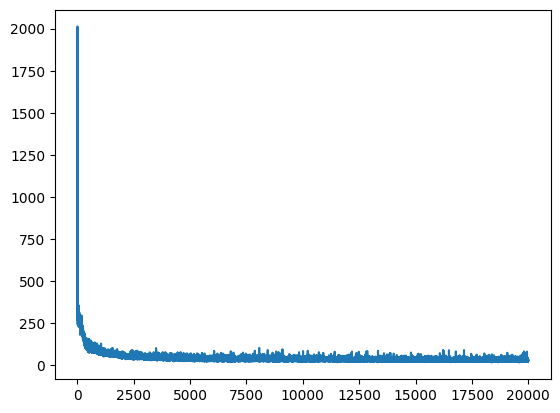

In [8]:
figsize(6.4,4.8)
plt.plot(loss_plot)
# plt.yscale('log')

# Samples from $q_t$

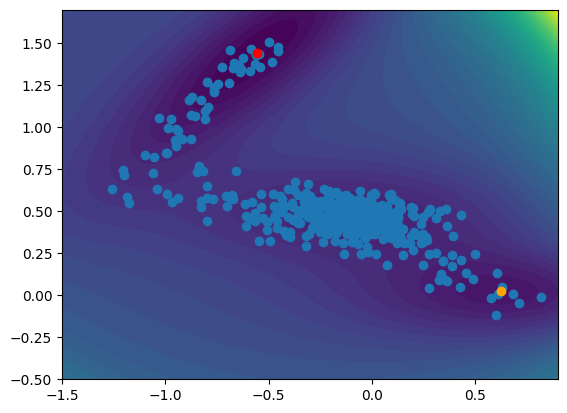

In [9]:
figsize(6.4,4.8)
t = T*jnp.linspace(0,1,BS).reshape((-1,1))
plt.contourf(x,y,z,50)
key, path_key = jax.random.split(key)
eps = jax.random.normal(path_key, [BS,ndim,1])
mu_t, S_t = state_q.apply_fn(state_q.params, t)
samples = mu_t + jax.lax.batch_matmul(S_t, eps).squeeze()
plt.scatter(samples[:,0], samples[:,1])
plt.scatter(A[0,0], A[0,1], color='red')
plt.scatter(B[0,0], B[0,1], color='orange')

# Sampling paths via the learned vector field
## Deterministically

In [10]:
mu_t = lambda _t: state_q.apply_fn(state_q.params, _t)[0]
S_t = lambda _t: state_q.apply_fn(state_q.params, _t)[1]
def dmudt(_t):
  _dmudt = jax.jacrev(lambda _t: mu_t(_t).sum(0))
  return _dmudt(_t).squeeze().T
def dSdt(_t):
  _dSdt = jax.jacrev(lambda _t: S_t(_t).sum(0))
  return _dSdt(_t).squeeze().T

@jax.jit
def u_t(_t, _x):
  S_t_val = S_t(_t)
  dSdt_val = dSdt(_t)
  dSigmadt = jax.lax.batch_matmul(dSdt_val, jnp.transpose(S_t_val, (0,2,1)))
  dSigmadt += jax.lax.batch_matmul(S_t_val, jnp.transpose(dSdt_val, (0,2,1)))
  STdlogdx = jax.scipy.linalg.solve_triangular(S_t_val, (_x - mu_t(_t))[...,None])
  dlogdx = -jax.scipy.linalg.solve_triangular(jnp.transpose(S_t_val, (0,2,1)), STdlogdx)
  # Sigma_t = jax.lax.batch_matmul(S_t_val, jnp.transpose(S_t_val, (0,2,1)))
  # dlogdx = -jax.lax.batch_matmul(jnp.linalg.inv(Sigma_t), (_x - mu_t(_t))[...,None])
  u_t = dmudt(_t) - 0.5*jax.lax.batch_matmul(dSigmadt, dlogdx).squeeze()
  return u_t

N = int(1e3)
dt = T/N
key, loc_key = jax.random.split(key)
x_t = jnp.ones((BS,N+1,ndim))*A
eps = jax.random.normal(key, shape=(BS,ndim,1))
x_t = x_t.at[:,0,:].set(x_t[:,0,:] + jax.lax.batch_matmul(S_t(jnp.zeros((BS,1))),eps).squeeze())
t = jnp.zeros((BS,1))
for i in trange(N):
  dxdt = u_t(t, x_t[:,i,:])
  # dxdt = dxdt.at[:,:2].set(x_t[:,i,2:])
  dx = dt*dxdt
  x_t = x_t.at[:,i+1,:].set(x_t[:,i,:] + dx)
  t += dt

x_t_det = x_t.copy()

100%|██████████| 1000/1000 [00:16<00:00, 62.18it/s]


## Stochastically

In [12]:
@jax.jit
def u_t_stoch(_t, _x):
  S_t_val = S_t(_t)# + 5e-2*jnp.eye(ndim)[None,...]
  dSdt_val = dSdt(_t)
  dSigmadt = jax.lax.batch_matmul(dSdt_val, jnp.transpose(S_t_val, (0,2,1)))
  dSigmadt += jax.lax.batch_matmul(S_t_val, jnp.transpose(dSdt_val, (0,2,1)))
  STdlogdx = jax.scipy.linalg.solve_triangular(S_t_val, (_x - mu_t(_t))[...,None])
  dlogdx = -jax.scipy.linalg.solve_triangular(jnp.transpose(S_t_val, (0,2,1)), STdlogdx)
  # Sigma_t = jax.lax.batch_matmul(S_t_val, jnp.transpose(S_t_val, (0,2,1)))
  # dlogdx = -jax.lax.batch_matmul(jnp.linalg.inv(Sigma_t), (_x - mu_t(_t))[...,None])
  out = dmudt(_t) + (-0.5*jax.lax.batch_matmul(dSigmadt, dlogdx) + 0.5*xi[...,None]**2*dlogdx).squeeze()
  return out, S_t_val

N = int(1e3)
dt = T/N
key, loc_key = jax.random.split(key)
x_t = jnp.ones((BS,N+1,ndim))*A
eps = jax.random.normal(key, shape=(BS,ndim,1))
x_t = x_t.at[:,0,:].set(x_t[:,0,:] + jax.lax.batch_matmul(S_t(jnp.zeros((BS,1))), eps).squeeze())
t = jnp.zeros((BS,1))
for i in trange(N):
  key, loc_key = jax.random.split(key)
  eps = jax.random.normal(key, shape=(BS,ndim))
  dxdt, dlogdx = u_t_stoch(t, x_t[:,i,:])
  # dxdt = dxdt.at[:,:2].set(x_t[:,i,2:])
  dx = dt*dxdt+jnp.sqrt(dt)*xi*eps
  x_t = x_t.at[:,i+1,:].set(x_t[:,i,:] + dx)
  t += dt

x_t_stoch = x_t.copy()

100%|██████████| 1000/1000 [00:04<00:00, 218.09it/s]


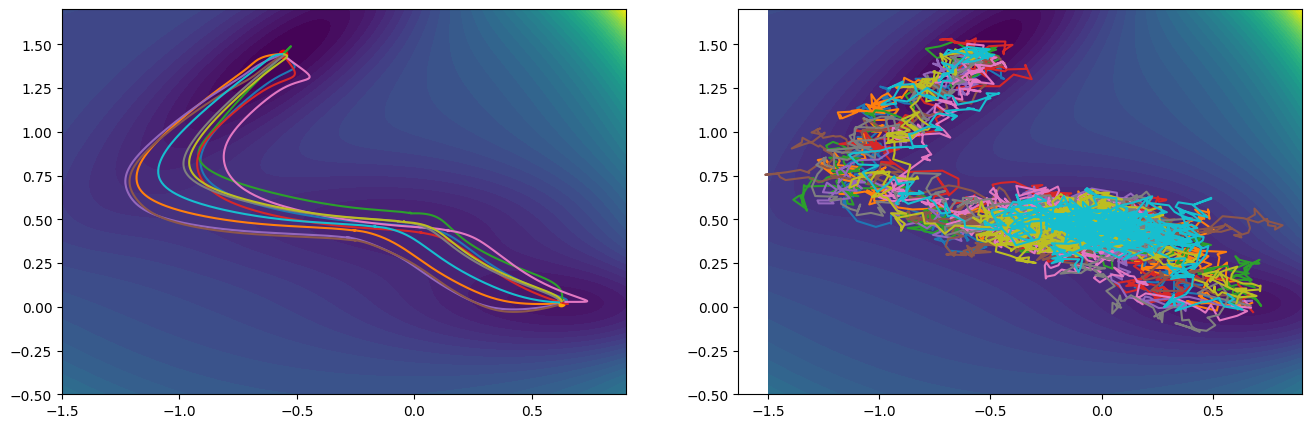

In [13]:
figsize(16,5)
plt.subplot(121)
plt.contourf(x,y,z,50)
plt.plot(x_t_det[:10,:,0].T, x_t_det[:10,:,1].T)
plt.scatter(A[0,0], A[0,1], color='red')
plt.scatter(B[0,0], B[0,1], color='orange')
plt.subplot(122)
plt.contourf(x,y,z,50)
plt.plot(x_t_stoch[:10,:,0].T, x_t_stoch[:10,:,1].T)
plt.scatter(A[0,0], A[0,1], color='red')
plt.scatter(B[0,0], B[0,1], color='orange')
plt.show()